**Install Libraries**

In [1]:
!pip install transformers[sentencepiece] datasets sacrebleu rouge_score py7zr -q

**Import Libraries**

In [2]:
from transformers import pipeline, set_seed

import matplotlib.pyplot as plt

import pandas as pd
from datasets import load_dataset, load_metric

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

import nltk
from nltk.tokenize import sent_tokenize

from tqdm import tqdm
import torch

# Download NLTK tokenizer data
nltk.download("punkt")

2024-06-24 09:49:32.285166: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-24 09:49:32.285321: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-24 09:49:32.407460: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
from datasets import load_dataset

**Initialize Pegasus model and tokenizer**

In [4]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"

model_ckpt = "google/pegasus-cnn_dailymail"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

model_pegasus = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

**Function to calculate ROUGE metric on test dataset**

In [5]:
def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements.
    
    Yields consecutive chunks from a list.

    Args:
        list_of_elements (List[Any]): The list to be divided into chunks.
        batch_size (int): The size of chunks.

    Yields:
        List[Any]: A chunk from the list of the specified size.
        
    """
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

def calculate_metric_on_test_ds(dataset, metric, model, tokenizer, 
                               batch_size=16, device=device, 
                               column_text="article", 
                               column_summary="highlights"):
    """
    Calculates a specified metric on a test dataset.

    Args:
        dataset (Dataset): The dataset to evaluate.
        metric (Metric): The metric to calculate.
        model (nn.Module): The model to evaluate.
        tokenizer (Tokenizer): The tokenizer to use for text processing.
        batch_size (int, optional): The batch size for evaluation.
        device (torch.device, optional): The device to use for computation.
        column_text (str, optional): The name of the text column in the dataset.
        column_summary (str, optional): The name of the summary column in the dataset.

    Returns:
        Dict[str, float]: The calculated metric scores.
    """
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):
        
        inputs = tokenizer(article_batch, max_length=1024,  truncation=True, 
                        padding="max_length", return_tensors="pt")
        
        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device), 
                         length_penalty=0.8, num_beams=8, max_length=128)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''
        
        # Finally, we decode the generated texts, 
        # replace the <n> token, and add the decoded texts with the references to the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, 
                                clean_up_tokenization_spaces=True) 
               for s in summaries]      
        
        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
        
        
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
        
    #  Finally compute and return the ROUGE scores.
    score = metric.compute()
    return score

**Loading Dataset**

In [6]:
dataset_dialogsum = load_dataset("knkarthick/dialogsum")
# Print split lengths and dataset features
split_lengths = [len(dataset_dialogsum[split])for split in dataset_dialogsum]

print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_dialogsum['train'].column_names}")

# Print an example dialogue and summary from the dataset
print("\nDialogue:")
print(dataset_dialogsum["test"][0]["dialogue"])

print("\nSummary:")
print(dataset_dialogsum["test"][0]["summary"])

Generating train split:   0%|          | 0/12460 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Split lengths: [12460, 500, 1500]
Features: ['id', 'dialogue', 'summary', 'topic']

Dialogue:
#Person1#: Ms. Dawson, I need you to take a dictation for me.
#Person2#: Yes, sir...
#Person1#: This should go out as an intra-office memorandum to all employees by this afternoon. Are you ready?
#Person2#: Yes, sir. Go ahead.
#Person1#: Attention all staff... Effective immediately, all office communications are restricted to email correspondence and official memos. The use of Instant Message programs by employees during working hours is strictly prohibited.
#Person2#: Sir, does this apply to intra-office communications only? Or will it also restrict external communications?
#Person1#: It should apply to all communications, not only in this office between employees, but also any outside communications.
#Person2#: But sir, many employees use Instant Messaging to communicate with their clients.
#Person1#: They will just have to change their communication methods. I don't want any - one using Ins

**Initialize Pegasus pipeline for summarization**

In [7]:
pipe = pipeline('summarization', model = model_ckpt )

# Example of summarization using Pegasus pipeline
pipe_out = pipe(dataset_dialogsum['test'][0]['dialogue'] )

print(pipe_out)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[{'summary_text': 'All office communications are restricted to email correspondence and official memos .<n>The use of Instant Message programs by employees during working hours is strictly prohibited .<n>Employees who persist in using Instant Messaging will first receive a warning and be placed on probation .'}]


In [8]:
print(pipe_out[0]["summary_text"].replace(" .<n>", ".\n"))

All office communications are restricted to email correspondence and official memos.
The use of Instant Message programs by employees during working hours is strictly prohibited.
Employees who persist in using Instant Messaging will first receive a warning and be placed on probation .


**Initialize ROUGE metric for evaluation**

In [9]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

rouge_metric = load_metric('rouge')

score = calculate_metric_on_test_ds(dataset_dialogsum['test'], rouge_metric, model_pegasus, tokenizer, column_text = 'dialogue', column_summary='summary', batch_size=8 )

/tmp/ipykernel_34/3136692427.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric('rouge')
/opt/conda/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


100%|██████████| 188/188 [21:56<00:00,  7.00s/it]


In [10]:
# Print ROUGE scores
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = ['pegasus'])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.246641,0.06343,0.186421,0.186551


**Histogram**

Token indices sequence length is longer than the specified maximum sequence length for this model (1073 > 1024). Running this sequence through the model will result in indexing errors


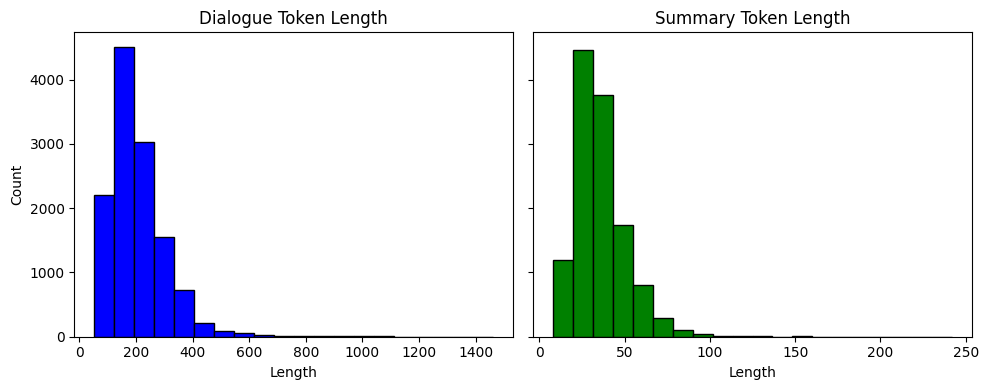

In [11]:
dialogue_token_len = [len(tokenizer.encode(s)) for s in dataset_dialogsum['train']['dialogue']]

summary_token_len = [len(tokenizer.encode(s)) for s in dataset_dialogsum['train']['summary']]


fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].hist(dialogue_token_len, bins = 20, color = 'blue', edgecolor = 'black' )
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(summary_token_len, bins = 20, color = 'green', edgecolor = 'black' )
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")

plt.tight_layout()
plt.show()

**Function to convert dataset examples to features for Seq2Seq model**

In [12]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['dialogue'] , max_length = 1024, truncation = True )
    
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['summary'], max_length = 128, truncation = True )
        
    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }
# Map dataset examples to features for Seq2Seq model training
dataset_dialogsum_pt = dataset_dialogsum.map(convert_examples_to_features, batched = True)

Map:   0%|          | 0/12460 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3946: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [13]:
from transformers import DataCollatorForSeq2Seq
#Data collator for Seq2Seq training
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_pegasus)

**Training**

In [14]:
# Training arguments for Trainer
from transformers import TrainingArguments, Trainer

trainer_args = TrainingArguments(
    output_dir='/kaggle/working/pegasus-dialogsum', num_train_epochs=2, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16
) 

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [15]:
# Trainer for Seq2Seq model training
trainer = Trainer(model=model_pegasus, args=trainer_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_dialogsum_pt["train"], 
                  eval_dataset=dataset_dialogsum_pt["validation"])

In [16]:
# Train Seq2Seq model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss
500,1.227700,1.165420
1000,1.162500,1.088809
1500,1.140000,1.074511


TrainOutput(global_step=1556, training_loss=1.3240080149437283, metrics={'train_runtime': 4634.9125, 'train_samples_per_second': 5.377, 'train_steps_per_second': 0.336, 'total_flos': 1.4448795020673024e+16, 'train_loss': 1.3240080149437283, 'epoch': 1.9980738362760835})

In [17]:
# Calculate ROUGE scores on test dataset using trained Seq2Seq model
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

rouge_metric = load_metric('rouge')

/opt/conda/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [18]:
# Print ROUGE scores
score = calculate_metric_on_test_ds(
    dataset_dialogsum['test'], rouge_metric, trainer.model, tokenizer, batch_size = 2, column_text = 'dialogue', column_summary= 'summary'
)

rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = [f'pegasus'] )

100%|██████████| 750/750 [20:11<00:00,  1.61s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.404575,0.165404,0.332067,0.332024


In [19]:
# Save Model
model_pegasus.save_pretrained("/kaggle/working/pegasus-dialogsum-model")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 128, 'min_length': 32, 'num_beams': 8, 'length_penalty': 0.8, 'forced_eos_token_id': 1}


In [20]:
# Save tokenizer
tokenizer.save_pretrained("/kaggle/working/tokenizer")

('/kaggle/working/tokenizer/tokenizer_config.json',
 '/kaggle/working/tokenizer/special_tokens_map.json',
 '/kaggle/working/tokenizer/spiece.model',
 '/kaggle/working/tokenizer/added_tokens.json',
 '/kaggle/working/tokenizer/tokenizer.json')

In [21]:
# Load
tokenizer = AutoTokenizer.from_pretrained("/kaggle/working/tokenizer")

**Generating Summaries**

In [23]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}



sample_text = dataset_dialogsum["test"][0]["dialogue"]

reference = dataset_dialogsum["test"][0]["summary"]

pipe = pipeline("summarization", model="/kaggle/working/pegasus-dialogsum-model",tokenizer=tokenizer)

print("Dialogue:")
print(sample_text)


print("\nReference Summary:")
print(reference)


print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Dialogue:
#Person1#: Ms. Dawson, I need you to take a dictation for me.
#Person2#: Yes, sir...
#Person1#: This should go out as an intra-office memorandum to all employees by this afternoon. Are you ready?
#Person2#: Yes, sir. Go ahead.
#Person1#: Attention all staff... Effective immediately, all office communications are restricted to email correspondence and official memos. The use of Instant Message programs by employees during working hours is strictly prohibited.
#Person2#: Sir, does this apply to intra-office communications only? Or will it also restrict external communications?
#Person1#: It should apply to all communications, not only in this office between employees, but also any outside communications.
#Person2#: But sir, many employees use Instant Messaging to communicate with their clients.
#Person1#: They will just have to change their communication methods. I don't want any - one using Instant Messaging in this office. It wastes too much time! Now, please continue with th